# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

# Set up

## Retrieve average mixed layer depth at the equator

In [2]:
mlotst = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_mlotst_piControl_2x2_15memens.nc')
mlotst

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
[354420000 values with dtype=float64]
Coordinates:
    latitude   (lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
  * time       (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat        (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon        (lon) int64 1 3 5 7 9 11 13 15 ... 345 347 349 351 353 355 357
  * name       (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'HadGEM3-GC31-LL'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    interp_method:  conserve_order1
    long_name:      Ocean Mixed Layer Thickness Defined by Sigma T
    original_name:  mlotst
    standard_name:  ocean_mixed_layer_thickness_defined_by_sigma_t
    units:          m

In [3]:
mlotst_equator = mlotst.sel(lat=0, method='nearest').mean('lon').mean('time').mean('name')
mlotst_equator

<xarray.DataArray ()>
array(21.95173968)
Coordinates:
    lat      int64 1

# Set parameters

In [4]:
density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 7*24*60*60 #Time in a week - seconds

In [5]:
mlotst_equator = 21.95173968

In [6]:
def white_noise(sigma):
    """
    Define white noise using a normal distribution
    
    """
    mean = 0
    std = sigma
    
    return np.random.normal(mean, std)

In [7]:
def integrate(params, years):
    """
    Integrating the white noise model 
    
    C dT/dt = -lambda T + F_o + F_a
    
    Inputs:
        params
            lambda_a = Atmospheric feedback
            sigma_a  = Variance of atmospheric forcing
            sigma_o  = Variance of oceanic forcing
            
    Outputs:
        T - Temperature [array]
        
    """
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    Nt = 52*years # Number of timesteps - weekly [weeks]
    dt = 60*60*24*7 # Timestep - week [s]
    
    np.random.seed(0)
    
    T = np.zeros(Nt+1) # Temperature array over time [K]
    
    F_o = white_noise(sigma_o)
    for t in range(1,Nt):
        if t%4 == 0:
            F_o = white_noise(sigma_o) # Monthly scale
        T[t+1] = T[t] + (dt/(c_p*density*mlotst_equator))*(-lambda_a*T[t] + white_noise(sigma_a) + F_o)
        
    return T    

In [8]:
def plot(params, years):
    fig, ax = plt.subplots()
    ax.plot(np.arange(years*52+1), T)
    ax.set_xticks(np.arange(0,years*52+1,52*100), np.arange(0,years+1,100))
    ax.set_title((r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' + str(params['sigma_o']) + r'  $\lambda_a$:' 
                  + str(params['lambda_a'])))
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('Temperature Anomaly [K]')
    fig.show()

# Running the Model

In [72]:
params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.08
params['sigma_o'] = 0.08

T = integrate(params, 1000)

# Tests with different parameters

Text(0, 0.5, 'Temperature Anomaly [K]')

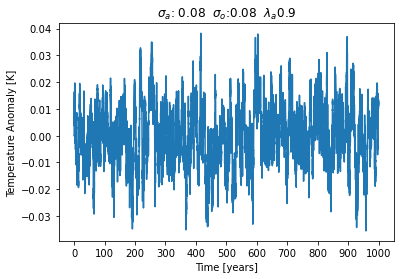

In [73]:
## Control

fig, ax = plt.subplots()
ax.plot(np.arange(1000*52+1), T)
ax.set_xticks(np.arange(0,1000*52+1,52*100), np.arange(0,1000+1,100))
ax.set_title((r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' + str(params['sigma_o']) + r'  $\lambda_a$' 
              + str(params['lambda_a'])))
ax.set_xlabel('Time [years]')
ax.set_ylabel('Temperature Anomaly [K]')

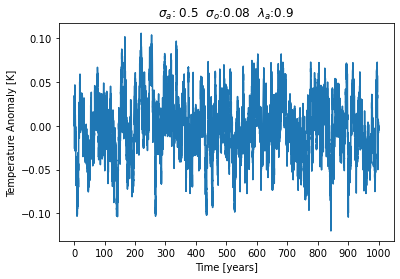

In [77]:
## Bring up atmospheric variance

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.5
params['sigma_o'] = 0.08
years = 1000

T = integrate(params, years)
plot(params, years)

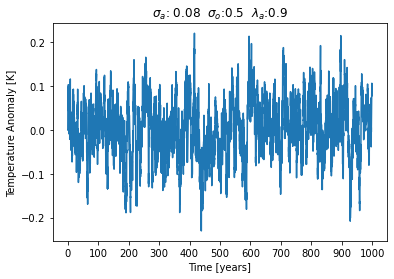

In [78]:
## Bring oceanic forcing

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.08
params['sigma_o'] = 0.5
years = 1000

T = integrate(params, years)
plot(params, years)

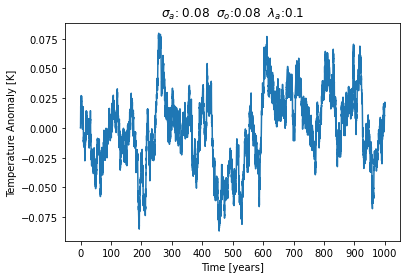

In [79]:
## Bring down feedback

params = {}
params['lambda_a'] = 0.1
params['sigma_a'] = 0.08
params['sigma_o'] = 0.08
years = 1000

T = integrate(params, years)
plot(params, years)

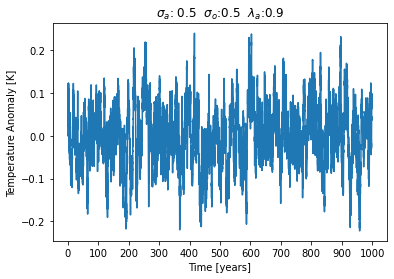

In [80]:
## Bring up both forcings

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000

T = integrate(params, years)
plot(params, years)

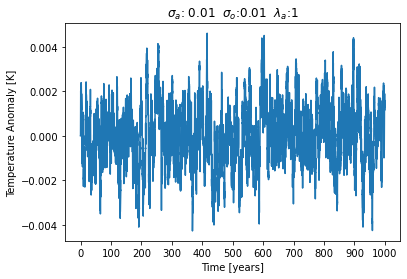

In [81]:
# Bring down forcings

params = {}
params['lambda_a'] = 1
params['sigma_a'] = 0.01
params['sigma_o'] = 0.01
years = 1000

T = integrate(params, years)
plot(params, years)

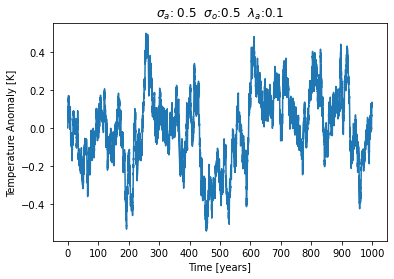

In [82]:
## Bring up forcings, bring down feedback

params = {}
params['lambda_a'] = 0.1
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000

T = integrate(params, years)
plot(params, years)

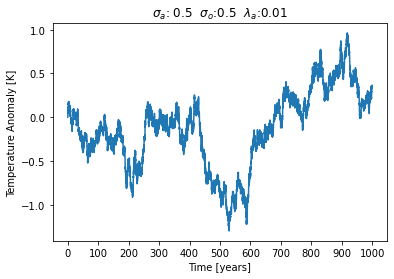

In [83]:
## Bring up forcings, bring down feedback much lower

params = {}
params['lambda_a'] = 0.01
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000

T = integrate(params, years)
plot(params, years)

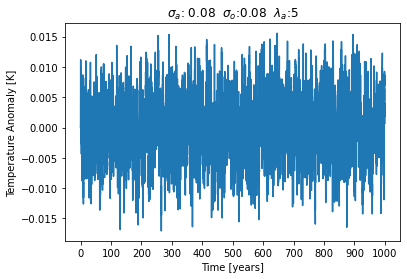

In [85]:
## Bring up feedback all the way

params = {}
params['lambda_a'] = 5
params['sigma_a'] = 0.08
params['sigma_o'] = 0.08
years = 1000

T = integrate(params, years)
plot(params, years)

# Regression

In [12]:
def lag_regress(params, years, lagint):
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    Nt = 52*years # Number of timesteps - weekly [weeks]
    dt = 60*60*24*7 # Timestep - week [s]
    
    np.random.seed(4)
    
    T = np.zeros(Nt+1) # Temperature array over time [K]
    
    F_o = white_noise(sigma_o)
    Q_toa = np.zeros(Nt)
    for t in range(1,Nt):
#        if t%1 == 0:
        F_o = white_noise(sigma_o) # Monthly scale
        Q_toa[t] = -lambda_a*T[t] + white_noise(sigma_a)
        T[t+1] = T[t] + (dt/(c_p*density*mlotst_equator))*(Q_toa[t] + F_o)
    
    lag_series = np.arange(-lagint,lagint,1)
    lagresponse = np.zeros(len(lag_series))
    i = 0
    for lag in lag_series:
        if lag < 0:
            laggedtoa = Q_toa[0:lag]
            T_trunc = np.roll(T, lag)[0:lag-1]
        elif lag == 0:
            laggedtoa = Q_toa
            T_trunc = T[:-1]
        elif lag > 0:    
            laggedtoa = np.roll(Q_toa,-lag)[0:-lag]
            T_trunc = T[0:-lag-1]
        lagresponse[i] = np.polyfit(T_trunc, laggedtoa, deg=1)[0]
        i += 1
    return lagresponse, lag_series

In [11]:
params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 100
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

Text(0.5, 1.0, 'Power Spectral Density (Params: $\\sigma_a$: 0.1  $\\sigma_o$:0.1  $\\lambda_a$:0.9)')

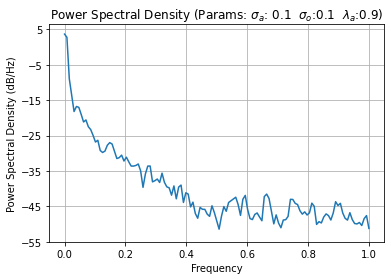

In [11]:
## Power spectral density

plt.psd(lagresponse)
plt.title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')

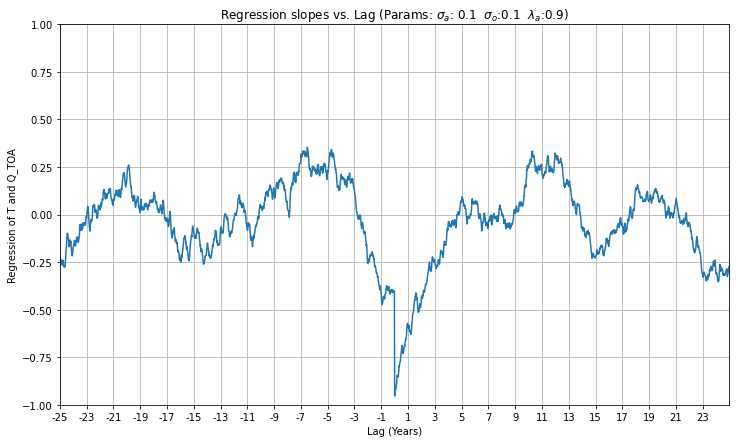

In [101]:
plt.rcParams['figure.figsize'] = [12, 7]
fig, ax = plt.subplots()
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1,1)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
plt.grid()

In [102]:
params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.01
params['sigma_o'] = 0.01
years = 100
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

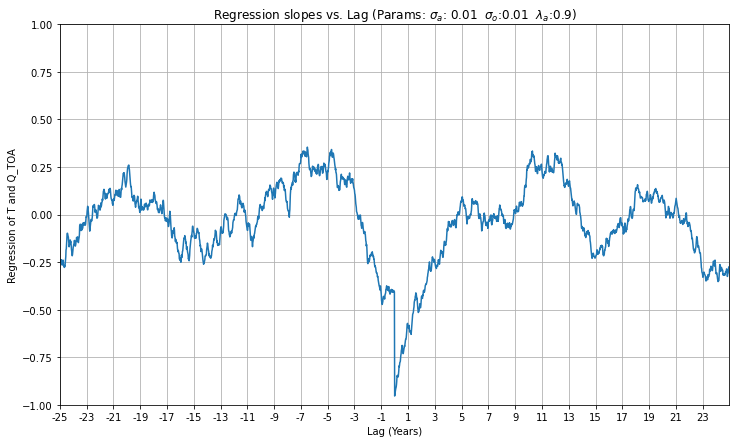

In [103]:
## Bringing down both forcings

plt.rcParams['figure.figsize'] = [12, 7]
fig, ax = plt.subplots()
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1,1)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
plt.grid()

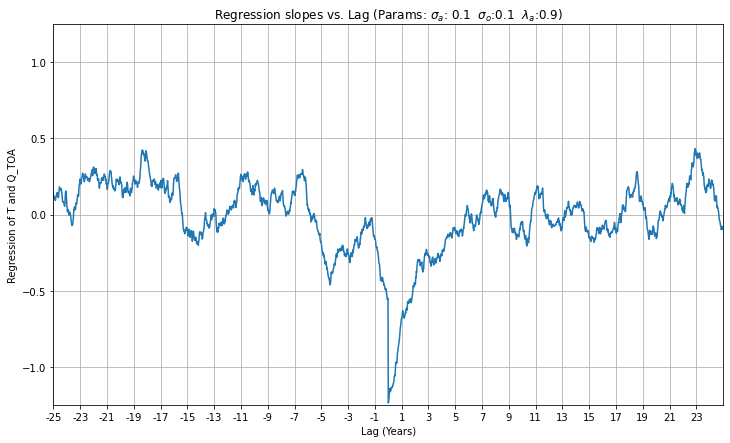

In [14]:
# Trying out a different seed - Seed 4

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 100
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, ax = plt.subplots()
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
plt.grid()

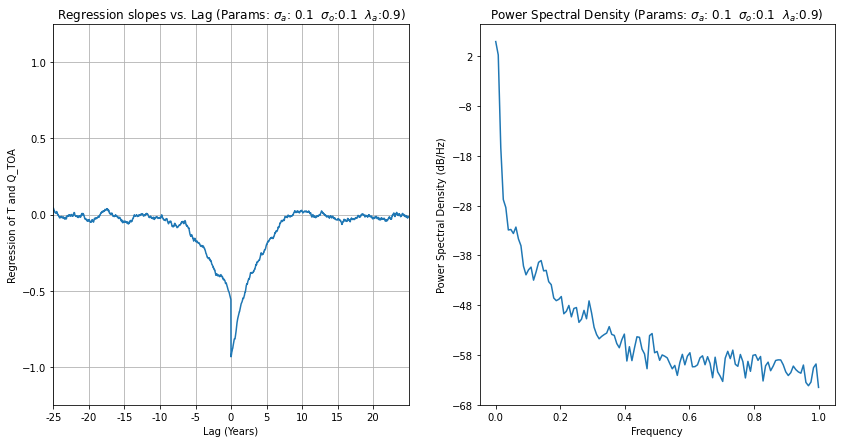

In [17]:
# sigma_a ~ sigma_o 1000 years

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

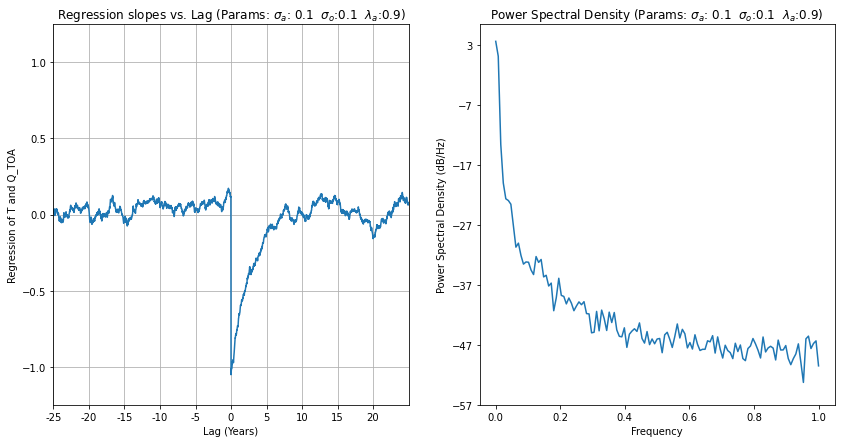

In [24]:
# sigma_a ~ sigma_o 1000 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

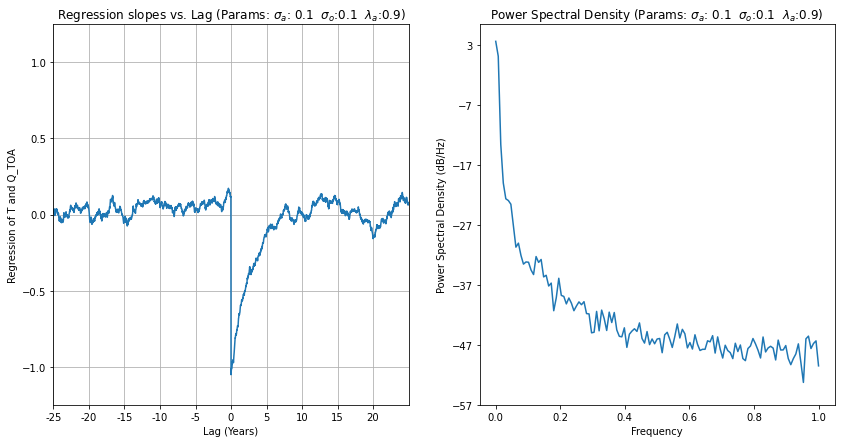

In [13]:

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

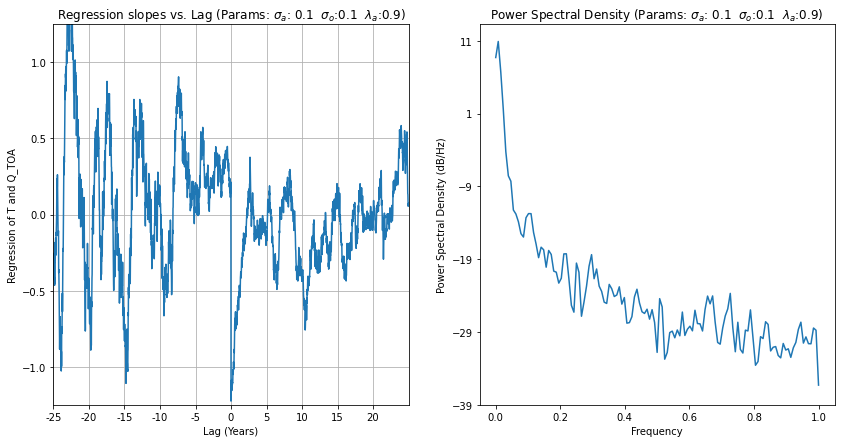

In [28]:
# sigma_a ~ sigma_o 50 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 50
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

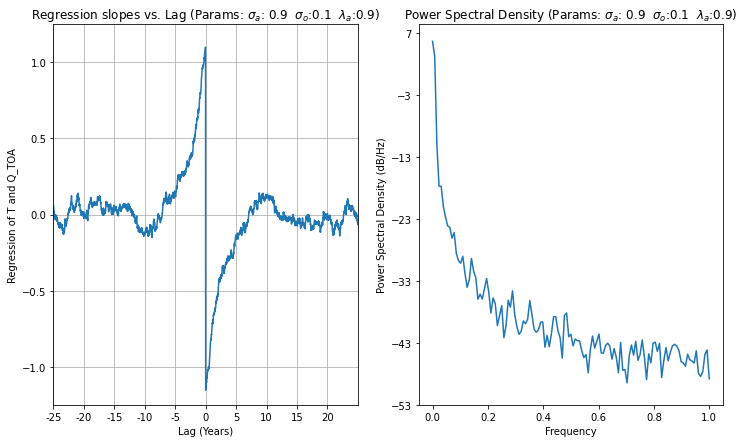

In [19]:
# sigma_a > sigma_o

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()

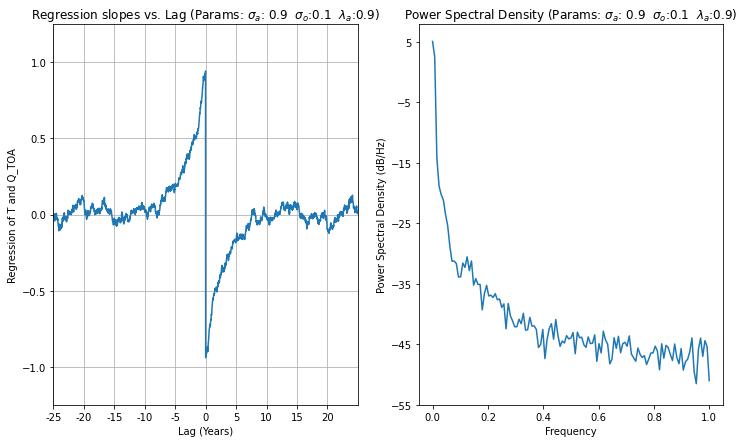

In [27]:
# sigma_a > sigma_o - Both on weekly forcing

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()


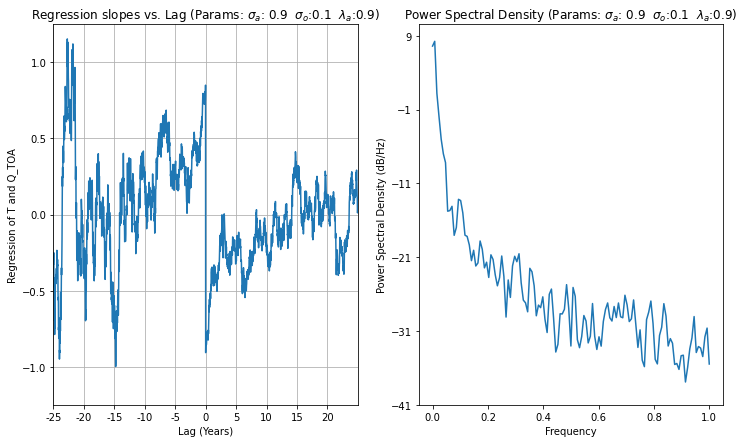

In [29]:
# sigma_a > sigma_o - Both on weekly forcing - 50 years

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 50
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()


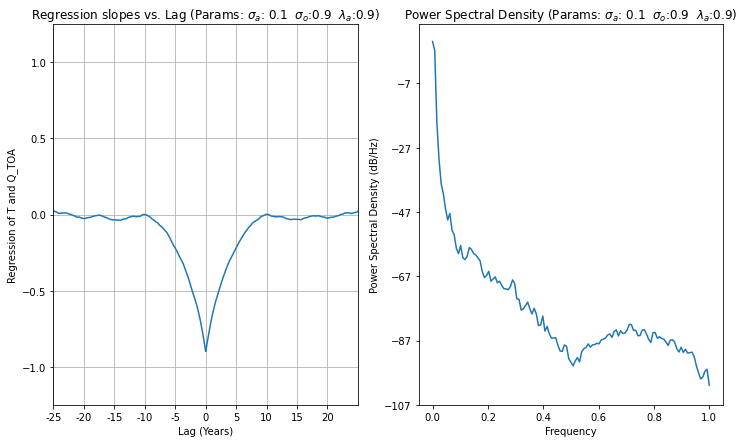

In [21]:
# sigma_a < sigma_o

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()

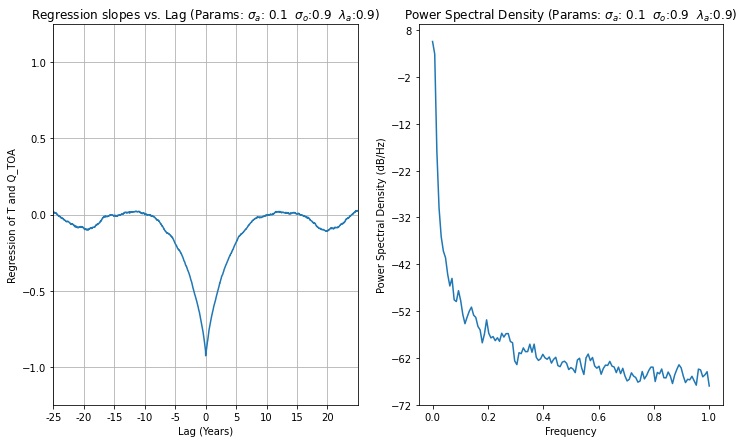

In [26]:
# sigma_a < sigma_o - Both on weekly forcing

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()

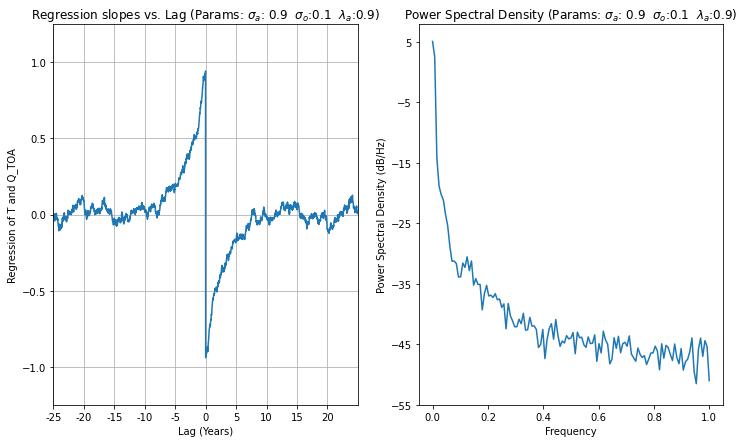

In [48]:
# sigma_o < sigma_a - Both on weekly forcing

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()

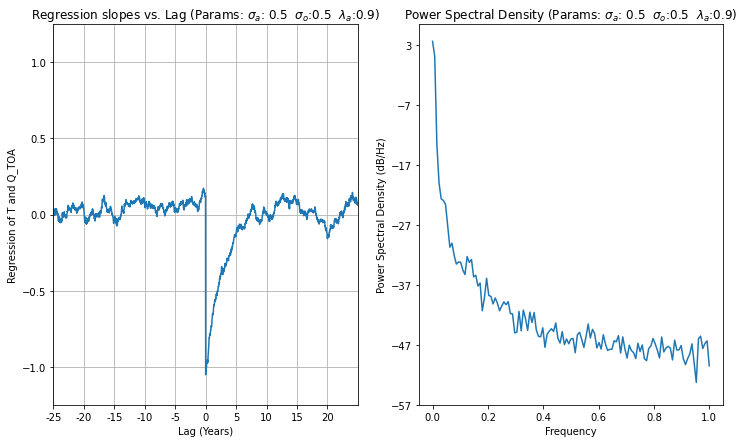

In [49]:
# sigma_o = sigma_a - Both on weekly forcing

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()

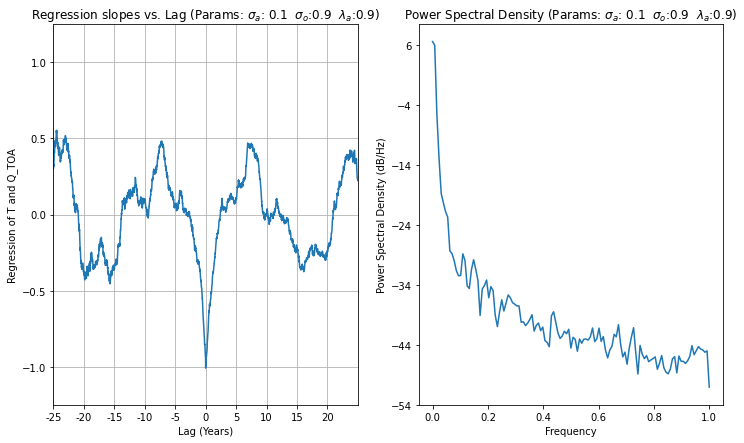

In [31]:
# sigma_a < sigma_o - Both on weekly forcing - 50 years

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 50
lagint = 52*25

lagresponse, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [12, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax2.grid()

# Analytical solution

In [9]:
# Analytical solution

def analytical(params, lagint):
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    dt = 60*60*24*7 # Timestep - week [s]
        
    lag_series = np.arange(-lagint,lagint,1)*dt
        
    c = c_p*density*mlotst_equator # Heat capacity
    
    w_0 = lambda_a/c

    eq_secondhalf = (w_0*c*2) * sigma_a**2/(sigma_a**2+sigma_o**2) * np.exp(-w_0*abs(lag_series))
    
    for i in range(len(eq_secondhalf)):
        if lag_series[i]>0:
            eq_secondhalf[i] = 0
        else:
            eq_secondhalf[i] = eq_secondhalf[i]
        
    # r_analytical = -np.exp(-lambda_a*abs(lag_series*dt)/c)*lambda_a
    r_analytical = -w_0*c*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)

    return r_analytical

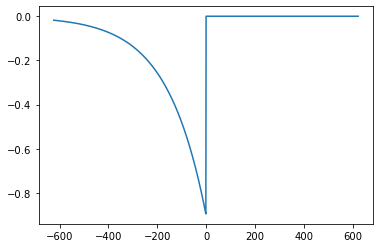

In [10]:
params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.1
years = 1000
lagint = 52*12

analyticalresponse = analytical(params, lagint)
lagseries = np.arange(-lagint,lagint,1)

plt.plot(lagseries, analyticalresponse)

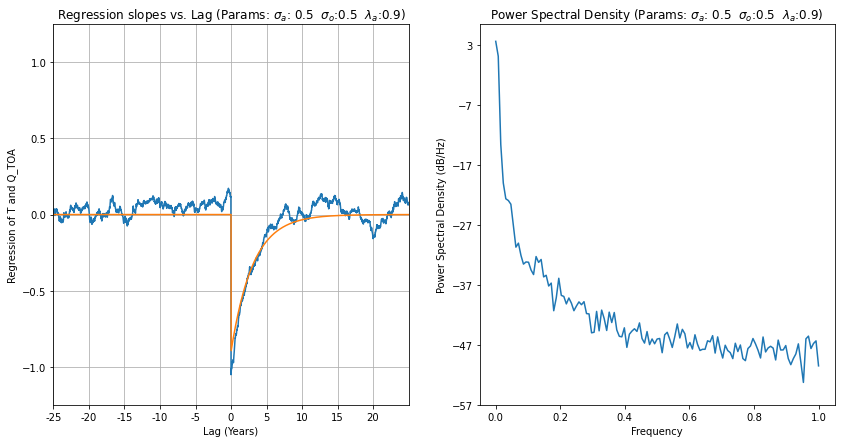

In [13]:
# sigma_a ~ sigma_o 1000 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000
lagint = 52*25 # In weeks

lagresponse, lagseries = lag_regress(params, years, lagint)
analyticalresponse = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.plot(lagseries, analyticalresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

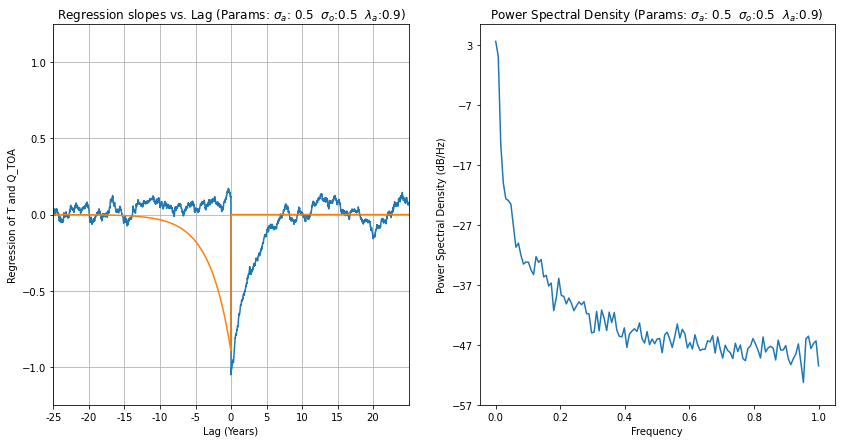

In [13]:
# sigma_a ~ sigma_o 1000 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000
lagint = 52*25 # In weeks

lagresponse, lagseries = lag_regress(params, years, lagint)
analyticalresponse = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.plot(lagseries, analyticalresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

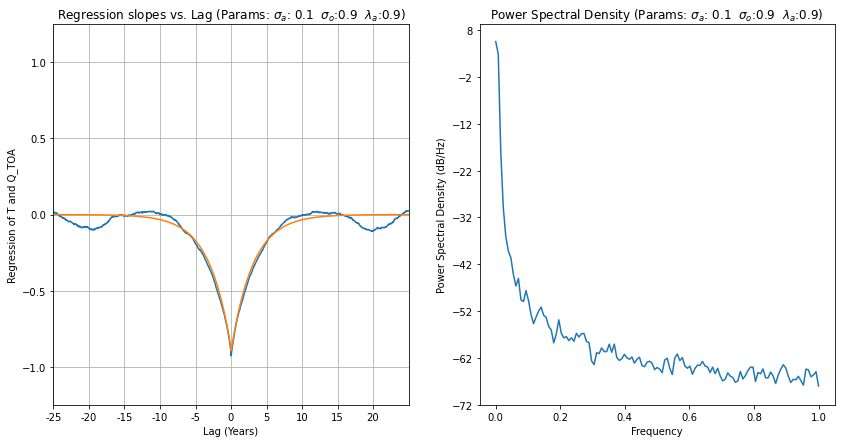

In [11]:
# sigma_a < sigma_o 1000 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 1000
lagint = 52*25 # In weeks

lagresponse, lagseries = lag_regress(params, years, lagint)
analyticalresponse = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.plot(lagseries, analyticalresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

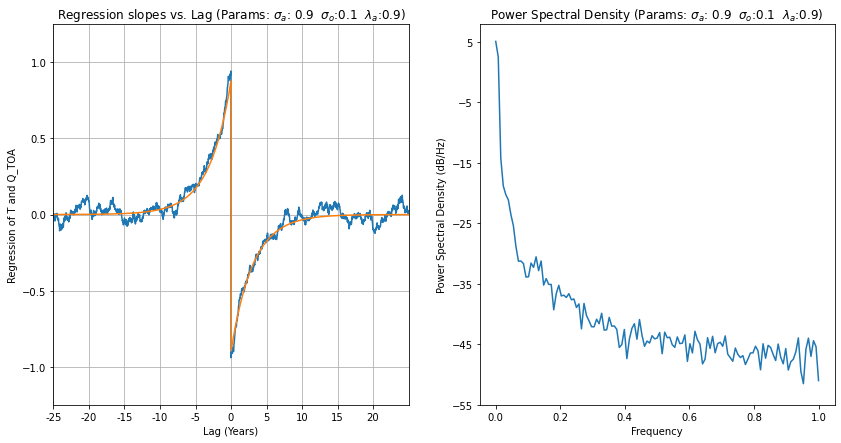

In [12]:
# sigma_a > sigma_o 1000 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25 # In weeks

lagresponse, lagseries = lag_regress(params, years, lagint)
analyticalresponse = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse)
ax.plot(lagseries, analyticalresponse)
ax.set_ylim(-1.25,1.25)
ax.set_xticks(np.arange(-52*25,52*25,52*5), np.arange(-25,25,5))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
ax.grid()

## Power spectral density

ax2.psd(lagresponse)
ax2.set_title('Power Spectral Density (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) + ')')
#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

# Cross-Covariance

In [ ]:
# Analytical solution

def analytical(params, lagint):
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    dt = 60*60*24*7 # Timestep - week [s]
        
    lag_series = np.arange(-lagint,lagint,1)*dt
        
    c = c_p*density*mlotst_equator # Heat capacity
    
    w_0 = lambda_a/c

    eq_secondhalf = (w_0*c*2) * sigma_a**2/(sigma_a**2+sigma_o**2) * np.exp(-w_0*abs(lag_series))
    
    for i in range(len(eq_secondhalf)):
        if lag_series[i]>0:
            eq_secondhalf[i] = 0
        else:
            eq_secondhalf[i] = eq_secondhalf[i]
        
    # r_analytical = -np.exp(-lambda_a*abs(lag_series*dt)/c)*lambda_a
    r_analytical = -w_0*c*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)

    return r_analytical

In [ ]:
def lag_regress(params, years, lagint):
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    Nt = 52*years # Number of timesteps - weekly [weeks]
    dt = 60*60*24*7 # Timestep - week [s]
    
    np.random.seed(4)
    
    T = np.zeros(Nt+1) # Temperature array over time [K]
    
    F_o = white_noise(sigma_o)
    Q_toa = np.zeros(Nt)
    for t in range(1,Nt):
        F_o = white_noise(sigma_o) # Monthly scale
        Q_toa[t] = -lambda_a*T[t] + white_noise(sigma_a)
        T[t+1] = T[t] + (dt/(c_p*density*mlotst_equator))*(Q_toa[t] + F_o)
    
    # Theoretical cross covariance
    
    lag_series = np.arange(-lagint,lagint,1)
    lagresponse = np.zeros(len(lag_series))
    i = 0
    for lag in lag_series:
        if lag < 0:
            laggedtoa = Q_toa[0:lag]
            T_trunc = np.roll(T, lag)[0:lag-1]
        elif lag == 0:
            laggedtoa = Q_toa
            T_trunc = T[:-1]
        elif lag > 0:    
            laggedtoa = np.roll(Q_toa,-lag)[0:-lag]
            T_trunc = T[0:-lag-1]
        lagresponse[i] = np.polyfit(T_trunc, laggedtoa, deg=1)[0]
        i += 1
    return lagresponse, lag_series

In [15]:
# sigma_a > sigma_o 1000 years - Both forcings on weekly timescale

params = {}
params['lambda_a'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25 # In weeks

lagresponse, lagseries = lag_regress(params, years)

np.cov()

# Testing

## Testing lags

In [51]:
test_array = np.array((0,1,2,3,4,5,6,7,8,9))
test_array = np.roll(test_array, 3)
print(test_array)
test_array = test_array[3:]
print(test_array)

test_array_2 = np.array((0,10,20,30,40,50,60,70,80,90))
test_array_2 = test_array_2[:-4]
print(test_array_2)

[7 8 9 0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[ 0 10 20 30 40 50]


In [83]:
lag = -3

test_array = np.array((0,1,2,3,4,5,6,7,8,9))
test_array_2 = np.array((0,10,20,30,40,50,60,70,80,90,100))

test_array = test_array[0:lag]
test_array_2 = np.roll(test_array_2, lag)[0:lag-1]
print(test_array)
print(test_array_2)

[0 1 2 3 4 5 6]
[30 40 50 60 70 80 90]


In [84]:
test_array = np.array((0,1,2,3,4,5,6,7,8,9))
test_array_2 = np.array((0,10,20,30,40,50,60,70,80,90,100))
lag = 3

test_array = np.roll(test_array,-lag)[0:-lag]
test_array_2 = test_array_2[0:-lag-1]
print(test_array)
print(test_array_2)

[3 4 5 6 7 8 9]
[ 0 10 20 30 40 50 60]
